## 8 - Research Question 3 (Binary)

How accurate are AoI-based metrics in predicting the current workload for teleoperators?

##### Imports

In [2]:
# Import
import os
import ast
import json
import pandas as pd
import numpy as np
import scipy as su
import warnings
from collections import defaultdict
# from typing import Dict
# from scipy.signal import
# from scikit-learn import

from matplotlib.path import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import dask.dataframe as dd

import pingouin as pg
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_rel
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import boxcox
from scipy.stats import friedmanchisquare
from scipy.stats import levene
from statsmodels.stats.anova import AnovaRM
from boruta import BorutaPy

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import StratifiedKFold, GroupKFold, GridSearchCV, train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

##### Data Loading (AoI)

In [2]:
# Load AoI ddfs into dictionary
root_dir = './aoi_data'
def load_aoi_data(root_dir): # Get csv file reads into one dictionary
    data = {}
    for file in os.listdir(root_dir):
        file_path = os.path.join(root_dir, file)
        file_name = os.path.splitext(file)[0]  # file name without '.csv'
        data[file_name] = dd.read_csv(file_path, encoding='utf-8')  # read and attach to dict
    return data

data = load_aoi_data(root_dir)
df = data['RQ3_features_bin'].compute()

class_names = ['Easy Slow', 'Hard Fast']
participant_ids = [1,2,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20]
scaler = StandardScaler()

warnings.filterwarnings("ignore", category=RuntimeWarning)

### 1. Support Vector Classifiers

##### Basic SVC

In [6]:
# Prepare Dataset
df_svc1 = df.copy()
df_svc1 = df_svc1.drop(columns=['participant_id']).dropna()
df_svc1['condition'] = df_svc1['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)

X = df_svc1.drop(columns=['condition'])
y = df_svc1['condition']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

df_svc1_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

In [7]:
# Classes unbalance (NaN dropped)
print(f"Low:\t{len(df_svc1_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_svc1_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 70.34%, (~0.79)
Precision: 72.16%, (~0.73)
Recall: 84.98%, (~0.85)
F1 Score: 77.97%, (~0.53)


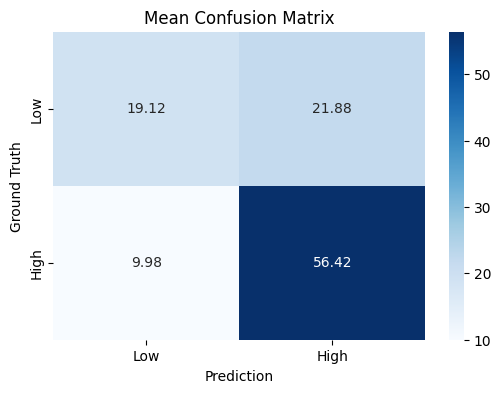

In [8]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = SVC(kernel='linear', random_state=random_state)

    inner_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-scaled SVC

In [3]:
# Prepare Dataset
df_svc2 = df.copy().dropna()
df_svc2['condition'] = df_svc2['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)

def scale_by_participant(group):
    scaler = StandardScaler()
    features = group.drop(columns=['participant_id', 'condition'])
    group_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns, index=group.index)
    return pd.concat([group_scaled, group[['condition']]], axis=1)
df_svc2_scaled = df_svc2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_svc2_scaled.drop(columns=['condition'])
y = df_svc2_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_7072\4001921656.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc2_scaled = df_svc2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [10]:
# Classes unbalance (NaN dropped)
print(f"Low:\t{len(df_svc2_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_svc2_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 78.32%, (~0.56)
Precision: 80.14%, (~0.29)
Recall: 86.48%, (~0.77)
F1 Score: 83.12%, (~0.49)


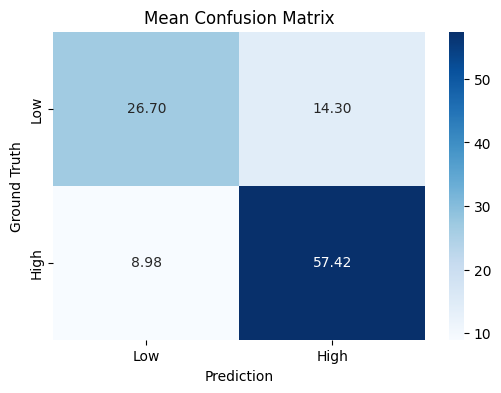

In [11]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = SVC(kernel='linear', random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Undersampled Participant-scaled SVC

In [12]:
# Prepare Dataset
df_svc3 = df.copy().dropna()
df_svc3['condition'] = df_svc3['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_svc3_scaled = df_svc3.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_svc3_scaled.drop(columns=['condition'])
y = df_svc3_scaled['condition']

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)
X_scaled_us, y_us = undersampler.fit_resample(X_scaled, y)
df_svc3_scaled_us = X_scaled_us.join(y_us)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\3938413815.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc3_scaled = df_svc3.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [13]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_svc3_scaled_us.query("condition == 0"))}")
print(f"High:\t{len(df_svc3_scaled_us.query("condition == 1"))}")

Low:	205
High:	205


Average Performance across multiple runs:
Accuracy: 77.24%, (~1.46)
Precision: 76.67%, (~1.69)
Recall: 78.63%, (~2.16)
F1 Score: 77.52%, (~1.49)


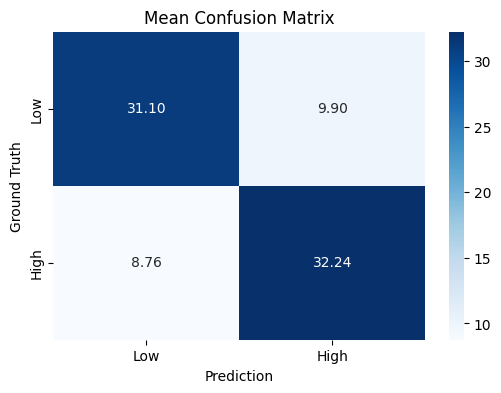

In [14]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_scaled_us, y_us = undersampler.fit_resample(X_scaled, y)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = SVC(kernel='linear', random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled_us, y_us):
        X_train, X_test = X_scaled_us.iloc[train_idx], X_scaled_us.iloc[test_idx]
        y_train, y_test = y_us.iloc[train_idx], y_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Oversampled Participant-scaled SVC

In [15]:
# Prepare Dataset
df_svc4 = df.copy().dropna()
df_svc4['condition'] = df_svc4['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_svc4_scaled = df_svc4.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_svc4_scaled.drop(columns=['condition'])
y = df_svc4_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\3039970190.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc4_scaled = df_svc4.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [16]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_svc4_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_svc4_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 76.93%, (~1.06)
Precision: 83.15%, (~1.15)
Recall: 78.80%, (~0.74)
F1 Score: 80.77%, (~0.87)


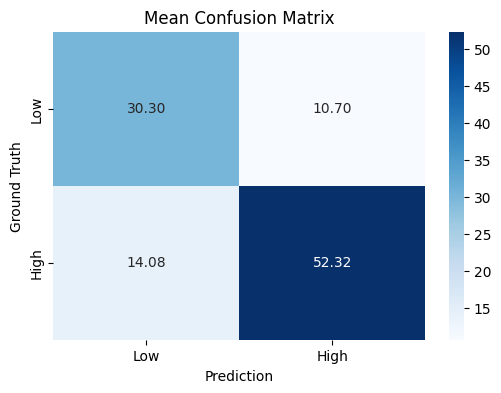

In [17]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='linear', random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-folded SVC

In [4]:
# Prepare Dataset
df_svc5 = df.copy().dropna()
df_svc5['condition'] = df_svc5['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_svc5_scaled = df_svc5.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_svc5.reset_index(drop=True)['participant_id']

X_scaled = df_svc5_scaled.drop(columns=['condition'])
y = df_svc5_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_13620\1065359793.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc5_scaled = df_svc5.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [5]:
# Classes unbalance (NaN dropped)
print(f"Low:\t{len(df_svc5_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_svc5_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 78.03%, (~0.00)
Precision: 80.12%, (~0.00)
Recall: 85.97%, (~0.00)
F1 Score: 82.88%, (~0.00)


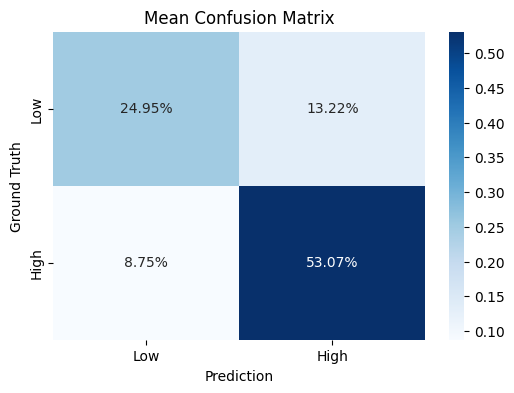

In [6]:
# Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = SVC(kernel='linear', random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]

        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [7]:
outer_results['best_params']

[[{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 100}, {'C': 1}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1000}, {'C': 1}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1000}, {'C': 1}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1000}, {'C': 1}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1000}, {'C': 1}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 100}, {'C': 1}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1000}, {'C': 1}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1000}, {'C': 1}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1000}, {'C': 1}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1000}, {'C': 1}]]

##### Oversampled Participant-folded SVC

In [38]:
# Prepare Dataset
df_svc6 = df.copy().dropna()
df_svc6['condition'] = df_svc6['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_svc6_scaled = df_svc6.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_svc6.reset_index(drop=True)['participant_id']

X_scaled = df_svc6_scaled.drop(columns=['condition'])
y = df_svc6_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_8332\3944293990.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc6_scaled = df_svc6.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [39]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_svc6_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_svc6_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 75.35%, (~0.44)
Precision: 81.28%, (~0.40)
Recall: 78.15%, (~0.89)
F1 Score: 79.61%, (~0.47)


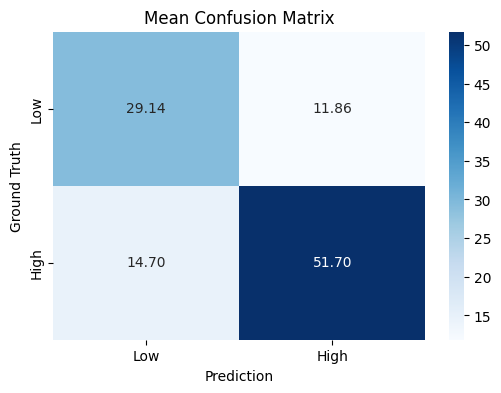

In [14]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='linear', random_state=random_state))
    ])
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [15]:
outer_results['best_params']

[[{'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1000},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 100},
  {'model__C': 10},
  {'model__C': 1}],
 [{'model__C': 100},
  {'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 0.1}],
 [{'model__C': 1},
  {'model__C': 100},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 10}],
 [{'model__C': 0.1},
  {'model__C': 100},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1}],
 [{'model__C': 100},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1}],
 [{'model__C': 0.1},
  {'model__C': 1000},
  {'model__C': 100},
  {'model__C': 1},
  {'model__C': 100}],
 [{'model__C': 100},
  {'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 0.1}],
 [{'model__C': 100},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model

##### Undersampled Participant-folded SVC

In [16]:
# Prepare Dataset
df_svc7 = df.copy().dropna()
df_svc7['condition'] = df_svc7['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_svc7_scaled = df_svc7.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_svc7.reset_index(drop=True)['participant_id']

X_scaled = df_svc7_scaled.drop(columns=['condition'])
y = df_svc7_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1688\301120295.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc7_scaled = df_svc7.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [17]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_svc7_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_svc7_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 75.21%, (~0.82)
Precision: 81.62%, (~0.72)
Recall: 77.36%, (~0.86)
F1 Score: 79.34%, (~0.71)


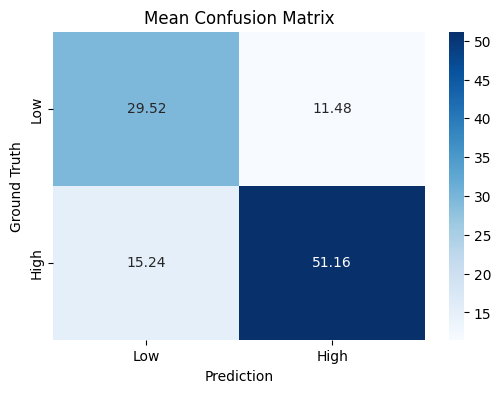

In [18]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='linear', random_state=random_state))
    ])
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [19]:
outer_results['best_params']

[[{'model__C': 10},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 1}],
 [{'model__C': 100},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1000},
  {'model__C': 100},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 10},
  {'model__C': 1},
  {'model__C': 1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 100},
  {'model__C': 100},
  {'model__C': 0.1},
  {'model__C': 1}],
 [{'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 1}],
 [{'model__C': 1},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 10}],
 [{'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 10},
  

### 2. Decision Tree Classifier

##### Basic DT Classifier

In [30]:
# Prepare Dataset
df_dt1 = df.copy()
df_dt1 = df_dt1.drop(columns=['participant_id']) #.dropna()
df_dt1['condition'] = df_dt1['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)

X = df_dt1.drop(columns=['condition'])
y = df_dt1['condition']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

df_dt1_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

In [31]:
# Classes unbalance
print(f"Low:\t{len(df_dt1_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_dt1_scaled.query("condition == 1"))}")

Low:	236
High:	344


Average Performance across multiple runs:
Accuracy: 65.95%, (~1.93)
Precision: 70.34%, (~1.97)
Recall: 75.03%, (~3.36)
F1 Score: 72.17%, (~1.70)


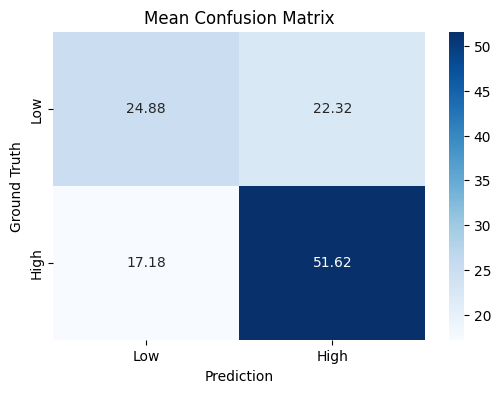

In [32]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-scaled DT Classifier

In [33]:
# Prepare Dataset
df_dt2 = df.copy() #.dropna()
df_dt2['condition'] = df_dt2['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)

df_dt2_scaled = df_dt2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_dt2_scaled.drop(columns=['condition'])
y = df_dt2_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\2566384299.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt2_scaled = df_dt2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [34]:
# Classes unbalance
print(f"Low:\t{len(df_dt2_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_dt2_scaled.query("condition == 1"))}")

Low:	236
High:	344


Average Performance across multiple runs:
Accuracy: 69.19%, (~1.66)
Precision: 74.39%, (~1.44)
Recall: 74.28%, (~4.04)
F1 Score: 73.96%, (~1.97)


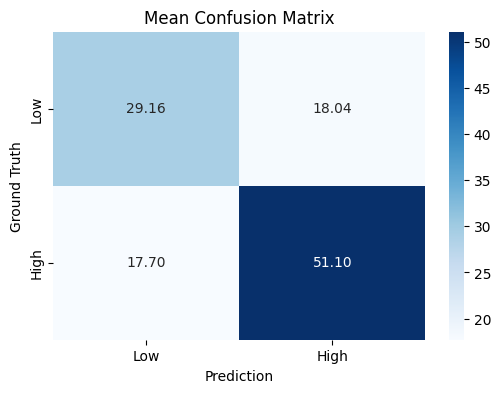

In [35]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Undersampled Participant-scaled DT Classifier

In [36]:
# Prepare Dataset
df_dt3 = df.copy()
df_dt3['condition'] = df_dt3['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_dt3_scaled = df_dt3.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_dt3_scaled.drop(columns=['condition'])
y = df_dt3_scaled['condition']

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)
X_scaled_us, y_us = undersampler.fit_resample(X_scaled, y)
df_dt3_scaled_us = X_scaled_us.join(y_us)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\3227870022.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt3_scaled = df_dt3.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [37]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_dt3_scaled_us.query("condition == 0"))}")
print(f"High:\t{len(df_dt3_scaled_us.query("condition == 1"))}")

Low:	236
High:	236


Average Performance across multiple runs:
Accuracy: 68.39%, (~2.14)
Precision: 68.59%, (~2.36)
Recall: 68.71%, (~3.54)
F1 Score: 68.32%, (~2.36)


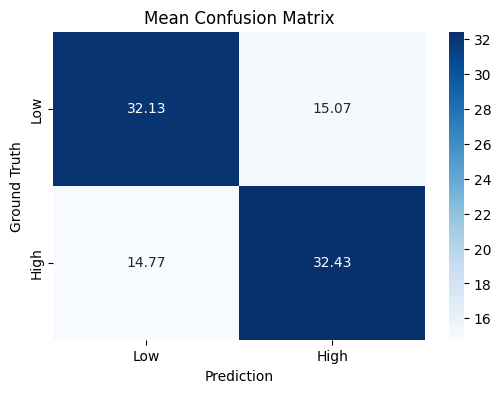

In [38]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 101):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_scaled_us, y_us = undersampler.fit_resample(X_scaled, y)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = DecisionTreeClassifier(criterion='gini', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled_us, y_us):
        X_train, X_test = X_scaled_us.iloc[train_idx], X_scaled_us.iloc[test_idx]
        y_train, y_test = y_us.iloc[train_idx], y_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Oversampled Participant-scaled DT Classifier

In [39]:
# Prepare Dataset
df_dt4 = df.copy().dropna()
df_dt4['condition'] = df_dt4['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_dt4_scaled = df_dt4.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_dt4_scaled.drop(columns=['condition'])
y = df_dt4_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\2507959881.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt4_scaled = df_dt4.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [40]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_dt4_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_dt4_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 68.16%, (~1.54)
Precision: 76.32%, (~1.11)
Recall: 70.64%, (~2.04)
F1 Score: 73.19%, (~1.46)


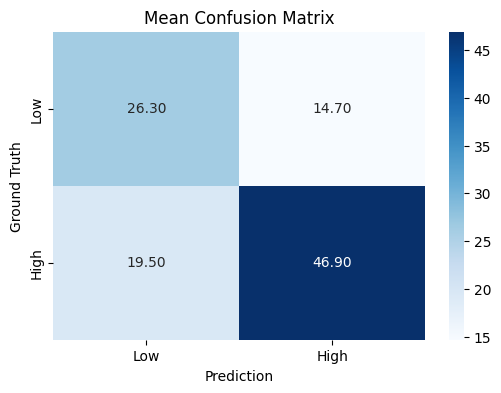

In [41]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', DecisionTreeClassifier(criterion='gini', random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-folded DT Classifier

In [35]:
# Prepare Dataset
df_dt5 = df.copy()
df_dt5['condition'] = df_dt5['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_dt5_scaled = df_dt5.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_dt5.reset_index(drop=True)['participant_id']

X_scaled = df_dt5_scaled.drop(columns=['condition'])
y = df_dt5_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_8332\3557052141.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt5_scaled = df_dt5.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [36]:
# Classes unbalance
print(f"Low:\t{len(df_dt5_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_dt5_scaled.query("condition == 1"))}")

Low:	236
High:	344


Average Performance across multiple runs:
Accuracy: 67.11%, (~1.31)
Precision: 71.72%, (~1.34)
Recall: 75.72%, (~1.35)
F1 Score: 73.25%, (~0.88)


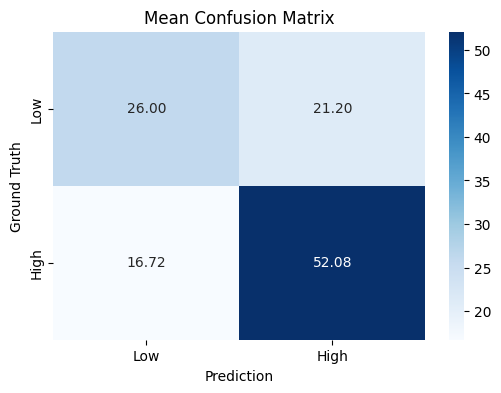

In [22]:
# Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]

        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [23]:
outer_results['best_params']

[[{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5},
  {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2},
  {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2},
  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10},
  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}],
 [{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5},
  {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2},
  {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2},
  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10},
  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}],
 [{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2},
  {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2},
  {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10},
  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10},
  {'max_depth': 10, 'min_samples_leaf': 

##### Oversampled Participant-folded DT

In [24]:
# Prepare Dataset
df_dt6 = df.copy().dropna()
df_dt6['condition'] = df_dt6['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_dt6_scaled = df_dt6.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_dt6.reset_index(drop=True)['participant_id']

X_scaled = df_dt6_scaled.drop(columns=['condition'])
y = df_dt6_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1688\610880391.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt6_scaled = df_dt6.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [25]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_dt6_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_dt6_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 66.20%, (~1.78)
Precision: 74.85%, (~1.22)
Recall: 68.85%, (~3.59)
F1 Score: 71.42%, (~2.10)


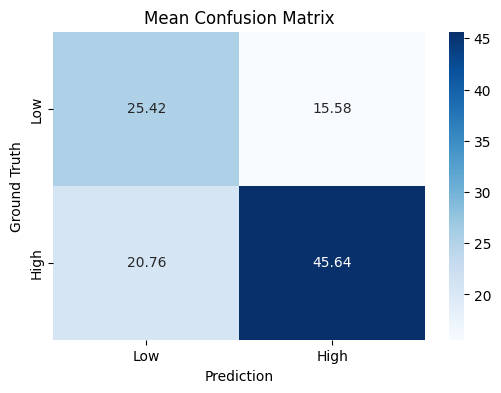

In [26]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', DecisionTreeClassifier(criterion='gini', random_state=random_state))
    ])
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [27]:
outer_results['best_params']

[[{'model__max_depth': None,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10},
  {'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2}],
 [{'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10},
  {'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2},
  {'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10}],
 [{'model__max_depth': None,
   'm

##### Undersampled Participant-folded DT

In [28]:
# Prepare Dataset
df_dt7 = df.copy().dropna()
df_dt7['condition'] = df_dt7['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_dt7_scaled = df_dt7.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_dt7.reset_index(drop=True)['participant_id']

X_scaled = df_dt7_scaled.drop(columns=['condition'])
y = df_dt7_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1688\2971086354.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt7_scaled = df_dt7.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [29]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_dt7_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_dt7_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 65.17%, (~3.10)
Precision: 76.32%, (~2.21)
Recall: 63.71%, (~4.59)
F1 Score: 69.04%, (~3.49)


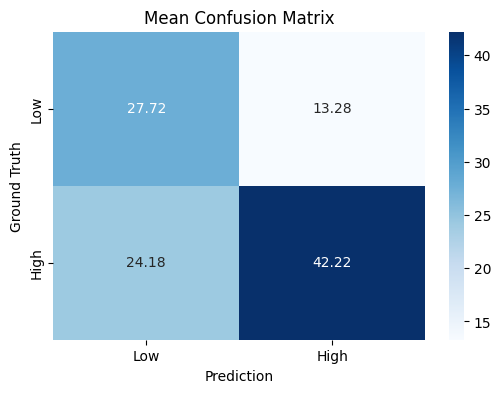

In [30]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', DecisionTreeClassifier(criterion='gini', random_state=random_state))
    ])
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [31]:
outer_results['best_params']

[[{'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 10},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5},
  {'model__max_depth': 3,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2},
  {'model__max_depth': None,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 10}],
 [{'model__max_depth': 3,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10},
  {'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2}],
 [{'model__max_depth': None,
   'model__min_sa

### 3. Random Forest Classifier

##### Basic RF Classifier

In [54]:
# Prepare Dataset
df_rf1 = df.copy()
df_rf1 = df_rf1.drop(columns=['participant_id']) #.dropna()
df_rf1['condition'] = df_rf1['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)

X = df_rf1.drop(columns=['condition'])
y = df_rf1['condition']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

df_rf1_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

In [55]:
# Classes unbalance
print(f"Low:\t{len(df_rf1_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_rf1_scaled.query("condition == 1"))}")

Low:	236
High:	344


Average Performance across multiple runs:
Accuracy: 75.36%, (~0.69)
Precision: 76.52%, (~0.61)
Recall: 84.63%, (~0.91)
F1 Score: 80.27%, (~0.58)


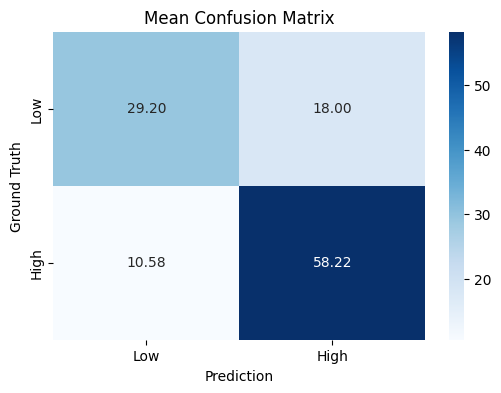

In [56]:
# Stratified nested cross-validation with multiple runs and hyper-parameter tuning
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-scaled RF Classifier

In [57]:
# Prepare Dataset
df_rf2 = df.copy() #.dropna()
df_rf2['condition'] = df_rf2['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)

df_rf2_scaled = df_rf2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_rf2_scaled.drop(columns=['condition'])
y = df_rf2_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\991876798.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf2_scaled = df_rf2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [58]:
# Classes unbalance
print(f"Low:\t{len(df_rf2_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_rf2_scaled.query("condition == 1"))}")

Low:	236
High:	344


Average Performance across multiple runs:
Accuracy: 79.19%, (~0.85)
Precision: 80.62%, (~0.85)
Recall: 85.73%, (~0.86)
F1 Score: 83.02%, (~0.66)


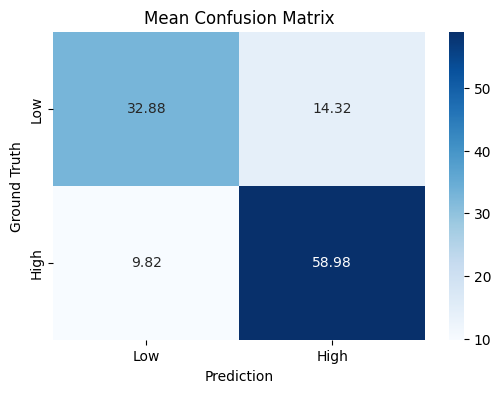

In [59]:
# Stratified nested cross-validation with multiple runs and hyper-parameter tuning
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Undersampled Participant-scaled RF Classifier

In [60]:
# Prepare Dataset
df_rf3 = df.copy()
df_rf3['condition'] = df_rf3['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_rf3_scaled = df_rf3.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_rf3_scaled.drop(columns=['condition'])
y = df_rf3_scaled['condition']

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)
X_scaled_us, y_us = undersampler.fit_resample(X_scaled, y)
df_rf3_scaled_us = X_scaled_us.join(y_us)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\660134788.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf3_scaled = df_rf3.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [61]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_rf3_scaled_us.query("condition == 0"))}")
print(f"High:\t{len(df_rf3_scaled_us.query("condition == 1"))}")

Low:	236
High:	236


Average Performance across multiple runs:
Accuracy: 77.90%, (~1.11)
Precision: 79.75%, (~1.80)
Recall: 75.30%, (~0.84)
F1 Score: 77.27%, (~0.96)


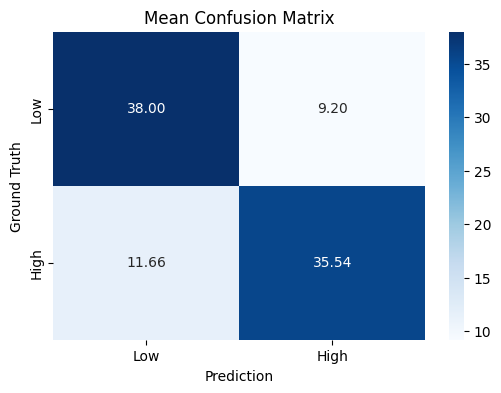

In [62]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_scaled_us, y_us = undersampler.fit_resample(X_scaled, y)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = RandomForestClassifier(criterion='gini', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled_us, y_us):
        X_train, X_test = X_scaled_us.iloc[train_idx], X_scaled_us.iloc[test_idx]
        y_train, y_test = y_us.iloc[train_idx], y_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Oversampled Participant-scaled RF Classifier

In [63]:
# Prepare Dataset
df_rf4 = df.copy().dropna()
df_rf4['condition'] = df_rf4['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_rf4_scaled = df_rf4.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_rf4_scaled.drop(columns=['condition'])
y = df_rf4_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\1890409341.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf4_scaled = df_rf4.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [64]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_rf4_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_rf4_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 78.12%, (~0.65)
Precision: 83.46%, (~0.70)
Recall: 80.82%, (~0.95)
F1 Score: 82.01%, (~0.59)


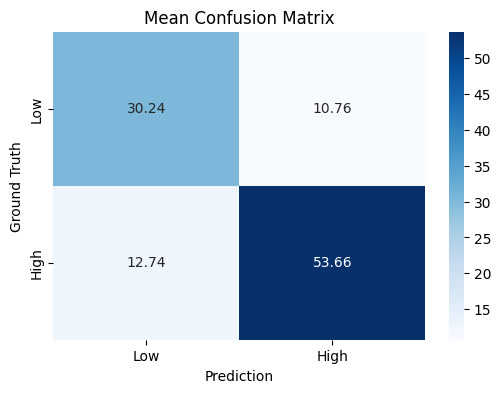

In [65]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [100, 1000],
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', RandomForestClassifier(criterion='gini', random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-folded RF Classifier

In [68]:
# Prepare Dataset
df_rf5 = df.copy()
df_rf5['condition'] = df_rf5['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_rf5_scaled = df_rf5.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_rf5.reset_index(drop=True)['participant_id']

X_scaled = df_rf5_scaled.drop(columns=['condition'])
y = df_rf5_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1688\4155311014.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf5_scaled = df_rf5.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [69]:
# Classes unbalance
print(f"Low:\t{len(df_rf5_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_rf5_scaled.query("condition == 1"))}")

Low:	236
High:	344


Average Performance across multiple runs:
Accuracy: 79.16%, (~0.96)
Precision: 80.94%, (~0.51)
Recall: 85.25%, (~1.72)
F1 Score: 82.97%, (~0.92)


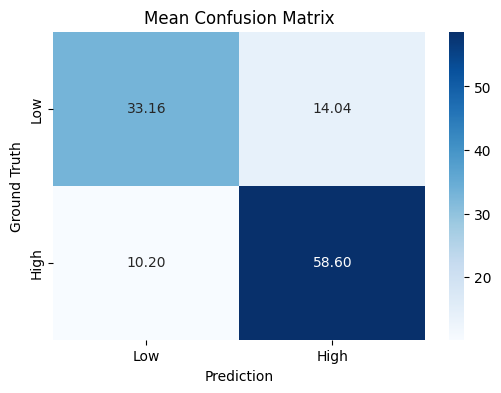

In [70]:
# Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]

        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [71]:
outer_results['best_params']

[[{'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 100},
  {'max_depth': 10,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 100},
  {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 10,
   'n_estimators': 1000},
  {'max_depth': None,
   'min_samples_leaf': 2,
   'min_samples_split': 2,
   'n_estimators': 100},
  {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 10,
   'n_estimators': 100}],
 [{'max_depth': 10,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 100},
  {'max_depth': 10,
   'min_samples_leaf': 4,
   'min_samples_split': 2,
   'n_estimators': 100},
  {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 5,
   'n_estimators': 1000},
  {'max_depth': 10,
   'min_samples_leaf': 1,
   'min_samples_split': 5,
   'n_estimators': 100},
  {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 1000}],
 

##### Oversampled Participant-folded RF

In [72]:
# Prepare Dataset
df_rf6 = df.copy().dropna()
df_rf6['condition'] = df_rf6['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_rf6_scaled = df_rf6.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_rf6.reset_index(drop=True)['participant_id']

X_scaled = df_rf6_scaled.drop(columns=['condition'])
y = df_rf6_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1688\1106783944.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf6_scaled = df_rf6.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [73]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_rf6_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_rf6_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 77.03%, (~0.78)
Precision: 82.50%, (~0.72)
Recall: 80.22%, (~1.00)
F1 Score: 81.19%, (~0.66)


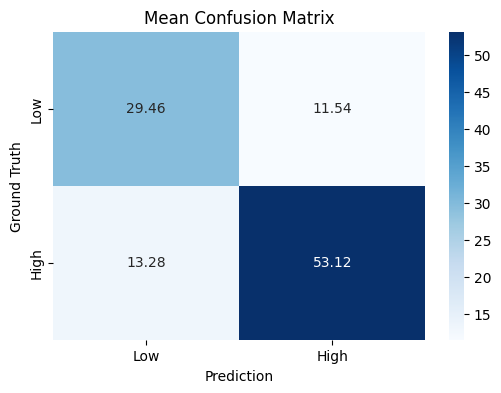

In [74]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [100, 1000],
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', RandomForestClassifier(criterion='gini', random_state=random_state))
    ])
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [75]:
outer_results['best_params']

[[{'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2,
   'model__n_estimators': 100},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2,
   'model__n_estimators': 100},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10,
   'model__n_estimators': 100},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2,
   'model__n_estimators': 100},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2,
   'model__n_estimators': 1000}],
 [{'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2,
   'model__n_estimators': 100},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2,
   'model__n_estimators': 1000},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2,
   'model__n_estimato

##### Undersampled Participant-folded RF

In [76]:
# Prepare Dataset
df_rf7 = df.copy().dropna()
df_rf7['condition'] = df_rf7['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_rf7_scaled = df_rf7.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_rf7.reset_index(drop=True)['participant_id']

X_scaled = df_rf7_scaled.drop(columns=['condition'])
y = df_rf7_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1688\1495728322.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf7_scaled = df_rf7.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [77]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_rf7_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_rf7_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 75.37%, (~0.95)
Precision: 84.60%, (~0.84)
Recall: 73.72%, (~1.65)
F1 Score: 78.64%, (~1.00)


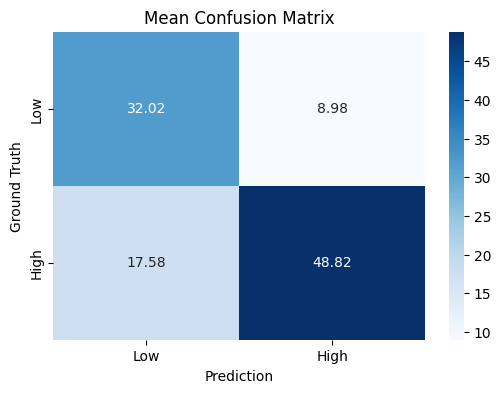

In [78]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [100, 1000],
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', RandomForestClassifier(criterion='gini', random_state=random_state))
    ])
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

    outer_results['best_params'].append(inner_results['best_params'])
print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [79]:
outer_results['best_params']

[[{'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__n_estimators': 1000},
  {'model__max_depth': None,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2,
   'model__n_estimators': 1000},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 10,
   'model__n_estimators': 100},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 10,
   'model__n_estimators': 1000},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__n_estimators': 100}],
 [{'model__max_depth': None,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__n_estimators': 1000},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__n_estimators': 1000},
  {'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2,
   'model__n

### 4. Gradient Boosting Machines Classifier

##### Basic GBM Classifier

In [78]:
# Prepare Dataset
df_gbm1 = df.copy()
df_gbm1 = df_gbm1.drop(columns=['participant_id']).dropna()
df_gbm1['condition'] = df_gbm1['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)

X = df_gbm1.drop(columns=['condition'])
y = df_gbm1['condition']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

df_gbm1_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

In [79]:
# Classes unbalance (NaN dropped)
print(f"Low:\t{len(df_gbm1_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_gbm1_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 73.45%, (~1.21)
Precision: 75.32%, (~1.29)
Recall: 85.39%, (~1.84)
F1 Score: 79.88%, (~0.91)


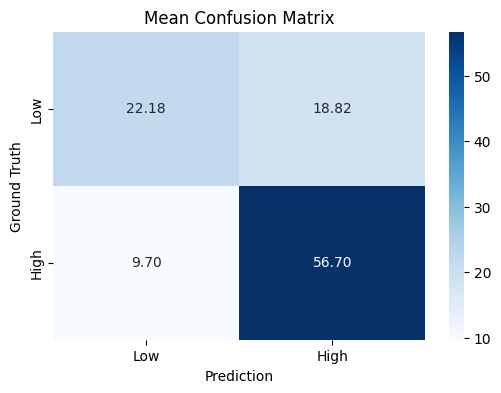

In [80]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = GradientBoostingClassifier(random_state=random_state)

    inner_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-scaled GBM Classifier

In [81]:
# Prepare Dataset
df_gbm2 = df.copy().dropna()
df_gbm2['condition'] = df_gbm2['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_gbm2_scaled = df_gbm2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_gbm2_scaled.drop(columns=['condition'])
y = df_gbm2_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\1781625871.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm2_scaled = df_gbm2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [82]:
# Classes unbalance (NaN dropped)
print(f"Low:\t{len(df_gbm2_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_gbm2_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 78.64%, (~1.43)
Precision: 80.10%, (~1.14)
Recall: 87.26%, (~1.23)
F1 Score: 83.46%, (~1.08)


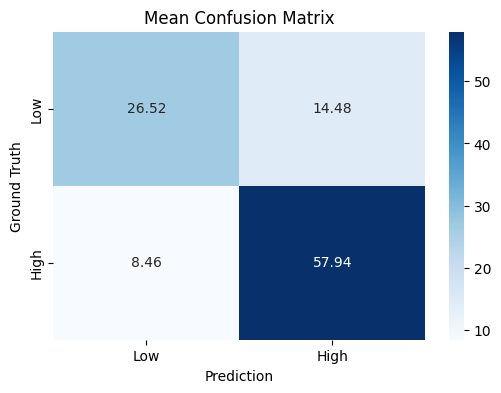

In [83]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = GradientBoostingClassifier(random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Undersampled Participant-scaled GBM Classifier

In [84]:
# Prepare Dataset
df_gbm3 = df.copy().dropna()
df_gbm3['condition'] = df_gbm3['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_gbm3_scaled = df_gbm3.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_gbm3_scaled.drop(columns=['condition'])
y = df_gbm3_scaled['condition']

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)
X_scaled_us, y_us = undersampler.fit_resample(X_scaled, y)
df_gbm3_scaled_us = X_scaled_us.join(y_us)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\1991141649.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm3_scaled = df_gbm3.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [85]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_gbm3_scaled_us.query("condition == 0"))}")
print(f"High:\t{len(df_gbm3_scaled_us.query("condition == 1"))}")

Low:	205
High:	205


Average Performance across multiple runs:
Accuracy: 77.02%, (~1.42)
Precision: 76.84%, (~1.07)
Recall: 77.80%, (~2.88)
F1 Score: 77.16%, (~1.79)


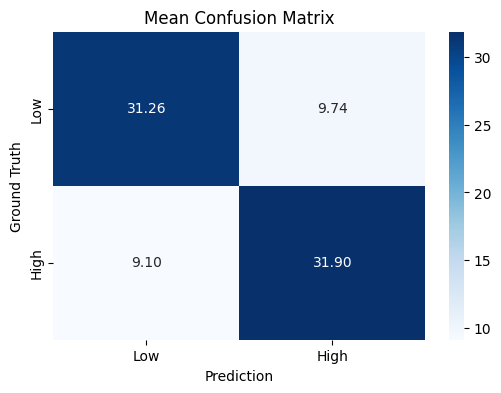

In [86]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_scaled_us, y_us = undersampler.fit_resample(X_scaled, y)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = GradientBoostingClassifier(random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled_us, y_us):
        X_train, X_test = X_scaled_us.iloc[train_idx], X_scaled_us.iloc[test_idx]
        y_train, y_test = y_us.iloc[train_idx], y_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Oversampled Participant-scaled GBM Classifier

In [87]:
# Prepare Dataset
df_gbm4 = df.copy().dropna()
df_gbm4['condition'] = df_gbm4['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_gbm4_scaled = df_gbm4.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_gbm4_scaled.drop(columns=['condition'])
y = df_gbm4_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\816032651.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm4_scaled = df_gbm4.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [88]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_gbm4_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_gbm4_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 78.48%, (~0.92)
Precision: 83.57%, (~0.98)
Recall: 81.33%, (~1.11)
F1 Score: 82.33%, (~0.76)


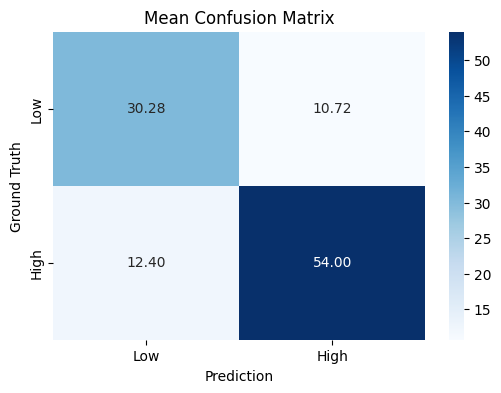

In [89]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', GradientBoostingClassifier(random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-folded GBM Classifier

In [32]:
# Prepare Dataset
df_gbm5 = df.copy().dropna()
df_gbm5['condition'] = df_gbm5['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_gbm5_scaled = df_gbm5.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_gbm5.reset_index(drop=True)['participant_id']

X_scaled = df_gbm5_scaled.drop(columns=['condition'])
y = df_gbm5_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1688\3974108838.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm5_scaled = df_gbm5.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [33]:
# Classes unbalance (NaN dropped)
print(f"Low:\t{len(df_gbm5_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_gbm5_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 76.90%, (~0.38)
Precision: 78.68%, (~0.46)
Recall: 85.87%, (~0.32)
F1 Score: 82.07%, (~0.27)


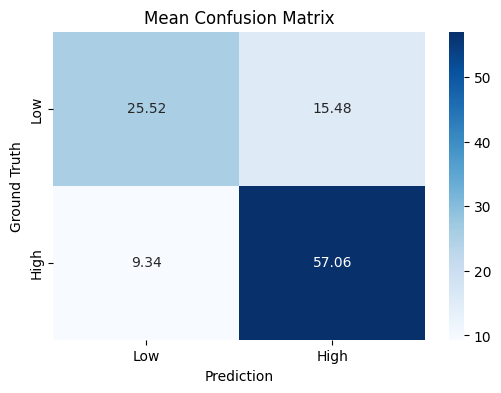

In [34]:
# Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = GradientBoostingClassifier(random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]

        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [35]:
outer_results['best_params']

[[{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50},
  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50},
  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100},
  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50},
  {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 200}],
 [{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50},
  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50},
  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100},
  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50},
  {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 200}],
 [{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50},
  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50},
  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100},
  {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 200},
  {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 200}],
 [{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

##### Oversampled Participant-folded GBM

In [36]:
# Prepare Dataset
df_gbm6 = df.copy().dropna()
df_gbm6['condition'] = df_gbm6['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_gbm6_scaled = df_gbm6.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_gbm6.reset_index(drop=True)['participant_id']

X_scaled = df_gbm6_scaled.drop(columns=['condition'])
y = df_gbm6_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1688\1991406289.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm6_scaled = df_gbm6.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [37]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_gbm6_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_gbm6_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 76.67%, (~1.49)
Precision: 81.56%, (~1.18)
Recall: 80.65%, (~1.90)
F1 Score: 81.01%, (~1.33)


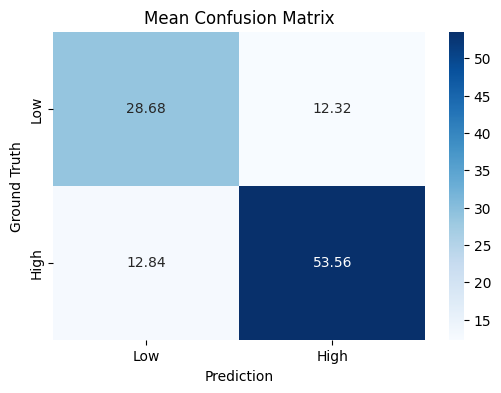

In [38]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', GradientBoostingClassifier(random_state=random_state))
    ])
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [39]:
outer_results['best_params']

[[{'model__learning_rate': 0.2,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 5,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.2,
   'model__max_depth': 2,
   'model__n_estimators': 100}],
 [{'model__learning_rate': 0.2,
   'model__max_depth': 5,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.2,
   'model__max_depth': 2,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 200}],
 [{'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 200},
  {'model__

##### Undersampled Participant-folded GBM

In [40]:
# Prepare Dataset
df_gbm7 = df.copy().dropna()
df_gbm7['condition'] = df_gbm7['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_gbm7_scaled = df_gbm7.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_gbm7.reset_index(drop=True)['participant_id']

X_scaled = df_gbm7_scaled.drop(columns=['condition'])
y = df_gbm7_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1688\1334718538.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm7_scaled = df_gbm7.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [41]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_gbm7_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_gbm7_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 75.43%, (~1.65)
Precision: 82.25%, (~1.53)
Recall: 76.90%, (~1.62)
F1 Score: 79.40%, (~1.42)


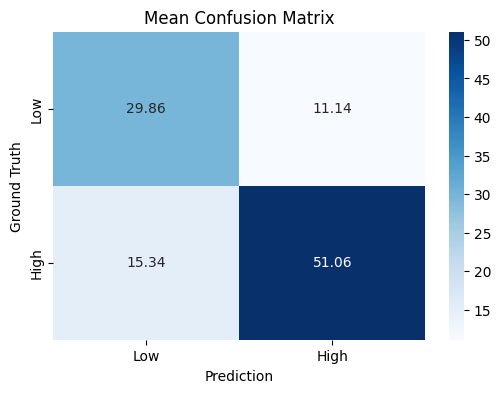

In [42]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', GradientBoostingClassifier(random_state=random_state))
    ])
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [43]:
outer_results['best_params']

[[{'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 5,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 100}],
 [{'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 200}],
 [{'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 50},
  {'model

### 5. Extreme Gradient Boosting Classifier

##### Basic XGB Classifier

In [102]:
# Prepare Dataset
df_xgb1 = df.copy()
df_xgb1 = df_xgb1.drop(columns=['participant_id'])#.dropna()
df_xgb1['condition'] = df_xgb1['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)

X = df_xgb1.drop(columns=['condition'])
y = df_xgb1['condition']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

df_xgb1_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

In [103]:
# Classes unbalance
print(f"Low:\t{len(df_xgb1_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_xgb1_scaled.query("condition == 1"))}")

Low:	236
High:	344


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Average Performance across multiple runs:
Accuracy: 75.16%, (~0.81)
Precision: 79.08%, (~0.98)
Recall: 79.34%, (~1.17)
F1 Score: 79.10%, (~0.63)


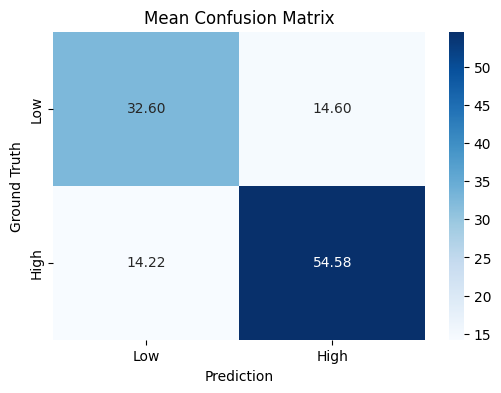

In [104]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = XGBClassifier(eval_metric='logloss', scale_pos_weight=(236/344), random_state=random_state)

    inner_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-scaled XGB Classifier

In [105]:
# Prepare Dataset
df_xgb2 = df.copy()#.dropna()
df_xgb2['condition'] = df_xgb2['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_xgb2_scaled = df_xgb2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_xgb2_scaled.drop(columns=['condition'])
y = df_xgb2_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\1014035808.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb2_scaled = df_xgb2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [106]:
# Classes unbalance
print(f"Low:\t{len(df_xgb2_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_xgb2_scaled.query("condition == 1"))}")

Low:	236
High:	344


Average Performance across multiple runs:
Accuracy: 79.03%, (~0.81)
Precision: 82.64%, (~0.67)
Recall: 82.21%, (~1.48)
F1 Score: 82.30%, (~0.83)


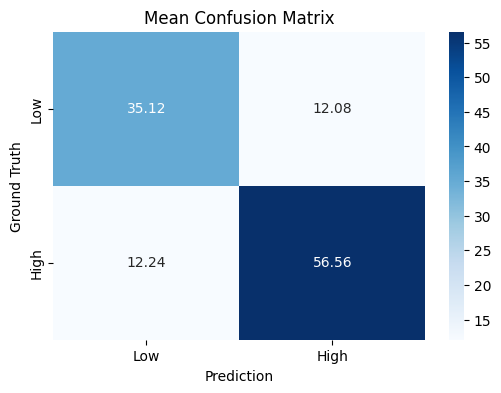

In [107]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = XGBClassifier(eval_metric='logloss', scale_pos_weight=(236/344), random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Undersampled Participant-scaled XGB Classifier

In [108]:
# Prepare Dataset
df_xgb3 = df.copy()#.dropna()
df_xgb3['condition'] = df_xgb3['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_xgb3_scaled = df_xgb3.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_xgb3_scaled.drop(columns=['condition'])
y = df_xgb3_scaled['condition']

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)
X_scaled_us, y_us = undersampler.fit_resample(X_scaled, y)
df_xgb3_scaled_us = X_scaled_us.join(y_us)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\2792415335.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb3_scaled = df_xgb3.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [109]:
# Classes (un)balance
print(f"Low:\t{len(df_xgb3_scaled_us.query("condition == 0"))}")
print(f"High:\t{len(df_xgb3_scaled_us.query("condition == 1"))}")

Low:	236
High:	236


Average Performance across multiple runs:
Accuracy: 77.67%, (~2.19)
Precision: 77.86%, (~2.28)
Recall: 77.80%, (~2.49)
F1 Score: 77.62%, (~2.17)


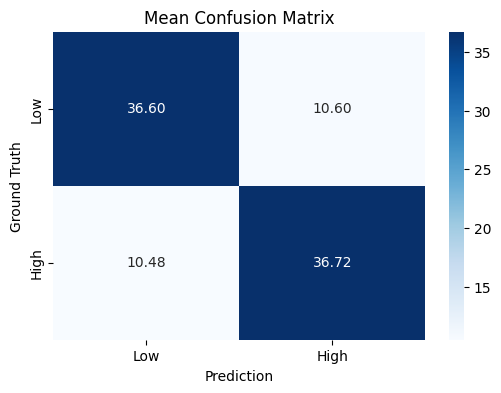

In [110]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_scaled_us, y_us = undersampler.fit_resample(X_scaled, y)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = XGBClassifier(eval_metric='logloss', random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled_us, y_us):
        X_train, X_test = X_scaled_us.iloc[train_idx], X_scaled_us.iloc[test_idx]
        y_train, y_test = y_us.iloc[train_idx], y_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Oversampled Participant-scaled XGB Classifier

In [111]:
# Prepare Dataset
df_xgb4 = df.copy().dropna()
df_xgb4['condition'] = df_xgb4['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_xgb4_scaled = df_xgb4.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_xgb4_scaled.drop(columns=['condition'])
y = df_xgb4_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\2009720476.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb4_scaled = df_xgb4.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [112]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_xgb4_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_xgb4_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 78.60%, (~0.86)
Precision: 83.66%, (~0.88)
Recall: 81.51%, (~1.34)
F1 Score: 82.44%, (~0.74)


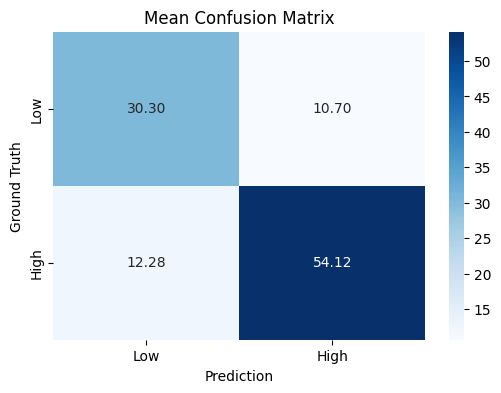

In [113]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5, 10],
    'model__gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', XGBClassifier(eval_metric='logloss', random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-folded XGB Classifier

In [4]:
# Prepare Dataset
df_xgb5 = df.copy()#.dropna()
df_xgb5['condition'] = df_xgb5['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_xgb5_scaled = df_xgb5.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_xgb5.reset_index(drop=True)['participant_id']

X_scaled = df_xgb5_scaled.drop(columns=['condition'])
y = df_xgb5_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_7072\2587418255.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb5_scaled = df_xgb5.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [5]:
# Classes unbalance
print(f"Low:\t{len(df_xgb5_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_xgb5_scaled.query("condition == 1"))}")

Low:	236
High:	344


Average Performance across multiple runs:
Accuracy: 78.55%, (~0.78)
Precision: 83.11%, (~0.80)
Recall: 80.44%, (~0.62)
F1 Score: 81.68%, (~0.65)


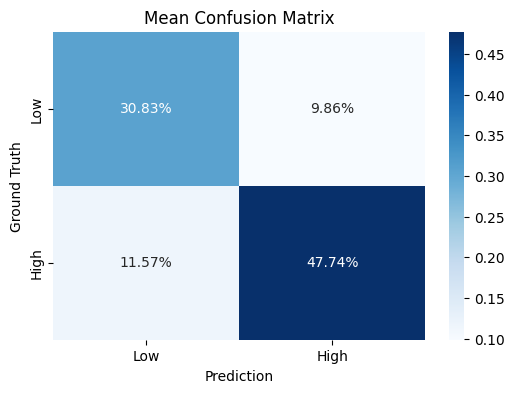

In [6]:
# Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = XGBClassifier(eval_metric='logloss', scale_pos_weight=(236/344), subsample=0.8, random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]

        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='recall', refit='recall', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [7]:
outer_results['best_params']

[[{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
  {'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200},
  {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100},
  {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200},
  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}],
 [{'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50},
  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100},
  {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100},
  {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200},
  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50}],
 [{'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200},
  {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50},
  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200

##### Oversampled Participant-folded XGB

In [8]:
# Prepare Dataset
df_xgb6 = df.copy().dropna()
df_xgb6['condition'] = df_xgb6['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_xgb6_scaled = df_xgb6.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_xgb6.reset_index(drop=True)['participant_id']

X_scaled = df_xgb6_scaled.drop(columns=['condition'])
y = df_xgb6_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_7072\1813935407.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb6_scaled = df_xgb6.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [9]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_xgb6_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_xgb6_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 76.84%, (~1.01)
Precision: 81.33%, (~0.82)
Recall: 81.26%, (~1.52)
F1 Score: 81.22%, (~0.93)


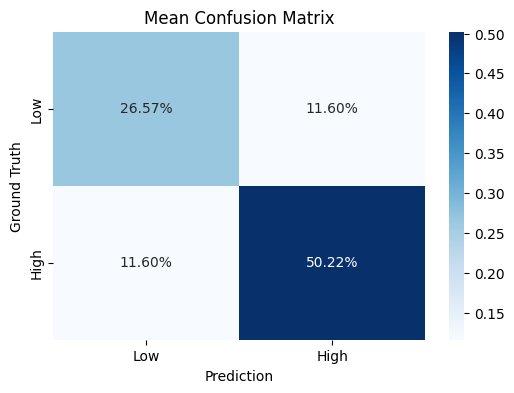

In [10]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5, 10],
    'model__gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', XGBClassifier(eval_metric='logloss', subsample=0.8, random_state=random_state))
    ])
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [11]:
outer_results['best_params']

[[{'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 100},
  {'model__gamma': 0.1,
   'model__learning_rate': 0.2,
   'model__max_depth': 10,
   'model__n_estimators': 200},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 10,
   'model__n_estimators': 200},
  {'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 200},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 100}],
 [{'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 10,
   'model__n_estimators': 200},
  {'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 10,
   'model__n_estimators': 100},
  {'model__gamma': 0.1,
   'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 200},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__

##### Undersampled Participant-folded XGB

In [12]:
# Prepare Dataset
df_xgb7 = df.copy().dropna()
df_xgb7['condition'] = df_xgb7['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_xgb7_scaled = df_xgb7.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_xgb7.reset_index(drop=True)['participant_id']

X_scaled = df_xgb7_scaled.drop(columns=['condition'])
y = df_xgb7_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_7072\554186123.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb7_scaled = df_xgb7.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [13]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_xgb7_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_xgb7_scaled.query("condition == 1"))}")

Low:	205
High:	332


Average Performance across multiple runs:
Accuracy: 77.52%, (~1.29)
Precision: 83.96%, (~0.97)
Recall: 78.75%, (~1.79)
F1 Score: 81.14%, (~1.21)


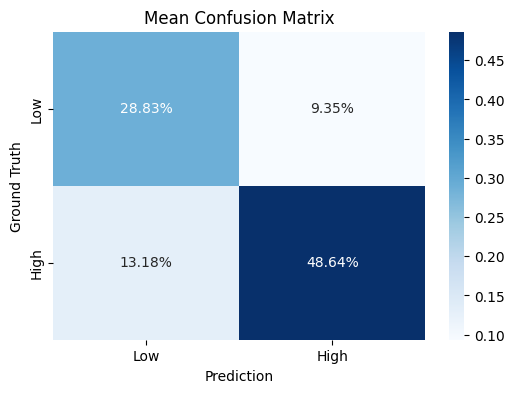

In [14]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5, 10],
    'model__gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', XGBClassifier(eval_metric='logloss', subsample=0.8, random_state=random_state))
    ])
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [15]:
outer_results['best_params']

[[{'model__gamma': 0.1,
   'model__learning_rate': 0.2,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.2,
   'model__max_depth': 5,
   'model__n_estimators': 200},
  {'model__gamma': 0.1,
   'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 200}],
 [{'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__gamma': 0.1,
   'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_est

### 6. Multilayer Perceptron Classifier

##### Basic MLP

In [126]:
# Prepare Dataset
df_mlp1 = df.copy()
df_mlp1 = df_mlp1.drop(columns=['participant_id']).dropna()
df_mlp1['condition'] = df_mlp1['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)

X = df_mlp1.drop(columns=['condition'])
y = df_mlp1['condition']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

df_mlp1_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

In [127]:
# Classes unbalance (NaN dropped)
print(f"Low:\t{len(df_mlp1_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_mlp1_scaled.query("condition == 1"))}")

Low:	205
High:	332


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 71.17%, (~1.94)
Precision: 76.21%, (~1.25)
Recall: 77.84%, (~2.40)
F1 Score: 76.84%, (~1.75)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


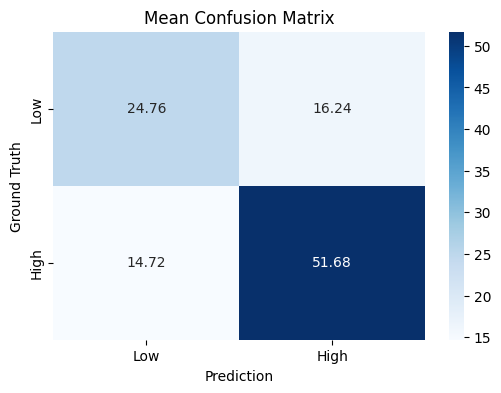

In [128]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'hidden_layer_sizes': [(20), (20, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):   
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state)

    inner_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-scaled MLP

In [129]:
# Prepare Dataset
df_mlp2 = df.copy().dropna()
df_mlp2['condition'] = df_mlp2['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)

df_mlp2_scaled = df_mlp2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_mlp2_scaled.drop(columns=['condition'])
y = df_mlp2_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\551709856.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp2_scaled = df_mlp2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [130]:
# Classes unbalance (NaN dropped)
print(f"Low:\t{len(df_mlp2_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_mlp2_scaled.query("condition == 1"))}")

Low:	205
High:	332


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 76.31%, (~0.71)
Precision: 80.48%, (~1.09)
Recall: 81.63%, (~1.60)
F1 Score: 80.92%, (~0.65)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


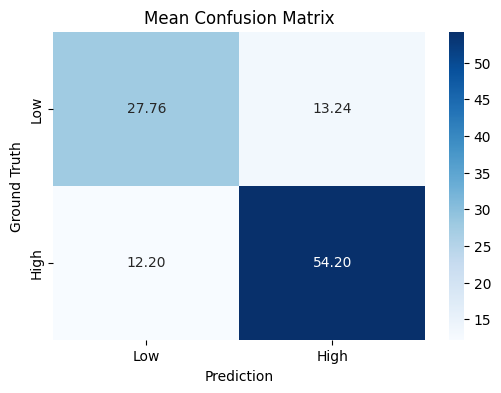

In [131]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'hidden_layer_sizes': [(20), (20, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Undersampled Participant-scaled MLP

In [132]:
# Prepare Dataset
df_mlp3 = df.copy().dropna()
df_mlp3['condition'] = df_mlp3['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_mlp3_scaled = df_mlp3.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_mlp3_scaled.drop(columns=['condition'])
y = df_mlp3_scaled['condition']

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)
X_scaled_us, y_us = undersampler.fit_resample(X_scaled, y)
df_mlp3_scaled_us = X_scaled_us.join(y_us)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\2804363688.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp3_scaled = df_mlp3.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [133]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_mlp3_scaled_us.query("condition == 0"))}")
print(f"High:\t{len(df_mlp3_scaled_us.query("condition == 1"))}")

Low:	205
High:	205


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 75.46%, (~1.58)
Precision: 75.13%, (~2.21)
Recall: 76.54%, (~1.76)
F1 Score: 75.67%, (~1.40)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


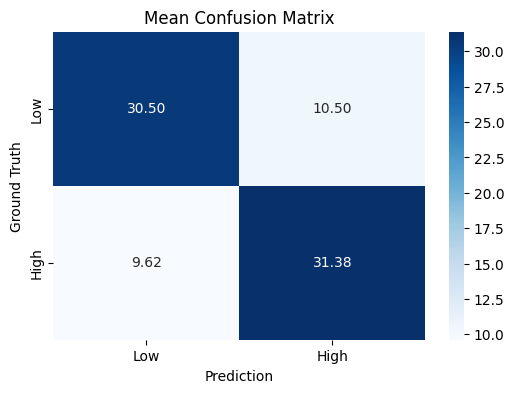

In [134]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'hidden_layer_sizes': [(20), (20, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_scaled_us, y_us = undersampler.fit_resample(X_scaled, y)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = MLPClassifier(max_iter=1000, shuffle=True,random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled_us, y_us):
        X_train, X_test = X_scaled_us.iloc[train_idx], X_scaled_us.iloc[test_idx]
        y_train, y_test = y_us.iloc[train_idx], y_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Oversampled Participant-scaled MLP

In [135]:
# Prepare Dataset
df_mlp4 = df.copy().dropna()
df_mlp4['condition'] = df_mlp4['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_mlp4_scaled = df_mlp4.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_mlp4_scaled.drop(columns=['condition'])
y = df_mlp4_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_21916\3093805420.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp4_scaled = df_mlp4.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [136]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_mlp4_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_mlp4_scaled.query("condition == 1"))}")

Low:	205
High:	332


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 75.21%, (~1.07)
Precision: 80.36%, (~0.94)
Recall: 79.49%, (~1.27)
F1 Score: 79.81%, (~0.91)


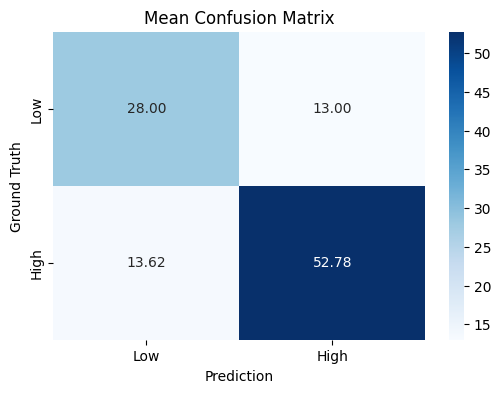

In [137]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__hidden_layer_sizes': [(20), (20, 10)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', MLPClassifier(max_iter=1000, shuffle=True,random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-folded MLP

In [56]:
# Prepare Dataset
df_mlp5 = df.copy().dropna()
df_mlp5['condition'] = df_mlp5['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_mlp5_scaled = df_mlp5.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_mlp5.reset_index(drop=True)['participant_id']

X_scaled = df_mlp5_scaled.drop(columns=['condition'])
y = df_mlp5_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1688\2333509078.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp5_scaled = df_mlp5.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [57]:
# Classes unbalance (NaN dropped)
print(f"Low:\t{len(df_mlp5_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_mlp5_scaled.query("condition == 1"))}")

Low:	205
High:	332


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 74.27%, (~1.12)
Precision: 78.79%, (~0.85)
Recall: 80.27%, (~2.28)
F1 Score: 79.37%, (~1.18)


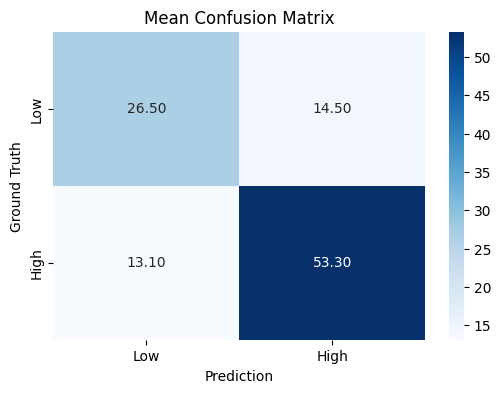

In [58]:
# Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'hidden_layer_sizes': [(20), (20, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]

        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [59]:
outer_results['best_params']

[[{'alpha': 0.001, 'hidden_layer_sizes': (20, 10), 'learning_rate_init': 0.1},
  {'alpha': 0.01, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.1},
  {'alpha': 0.0001,
   'hidden_layer_sizes': (20, 10),
   'learning_rate_init': 0.001},
  {'alpha': 0.0001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.01},
  {'alpha': 0.01, 'hidden_layer_sizes': (20, 10), 'learning_rate_init': 0.01}],
 [{'alpha': 0.001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.01},
  {'alpha': 0.0001, 'hidden_layer_sizes': (20, 10), 'learning_rate_init': 0.1},
  {'alpha': 0.001, 'hidden_layer_sizes': (20, 10), 'learning_rate_init': 0.01},
  {'alpha': 0.0001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.01},
  {'alpha': 0.0001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001}],
 [{'alpha': 0.01, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.0001, 'hidden_layer_sizes': (20, 10), 'learning_rate_init': 0.1},
  {'alpha': 0.001, 'hidden_layer_sizes': (20, 10), 'learning_rate_

##### Oversampled Participant-folded MLP

In [60]:
# Prepare Dataset
df_mlp6 = df.copy().dropna()
df_mlp6['condition'] = df_mlp6['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_mlp6_scaled = df_mlp6.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_mlp6.reset_index(drop=True)['participant_id']

X_scaled = df_mlp6_scaled.drop(columns=['condition'])
y = df_mlp6_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1688\1562931582.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp6_scaled = df_mlp6.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [61]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_mlp6_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_mlp6_scaled.query("condition == 1"))}")

Low:	205
High:	332


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 74.61%, (~0.91)
Precision: 79.58%, (~0.68)
Recall: 79.65%, (~1.45)
F1 Score: 79.49%, (~0.85)


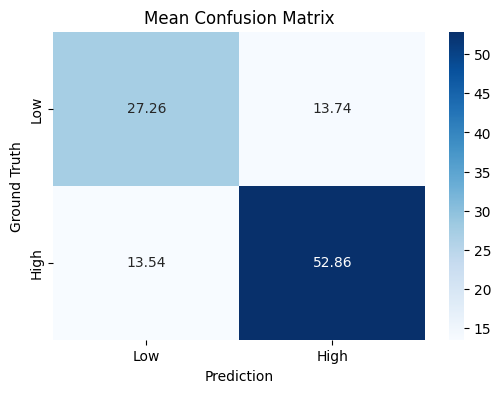

In [62]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__hidden_layer_sizes': [(20), (20, 10)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state))
    ])
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [63]:
outer_results['best_params']

[[{'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.1},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.1},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.01},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001}],
 [{'model__alpha': 0.001,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.1},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model

##### Undersampled Participant-folded MLP

In [64]:
# Prepare Dataset
df_mlp7 = df.copy().dropna()
df_mlp7['condition'] = df_mlp7['condition'].apply(lambda x: 0 if x == 'Easy Slow' else 1)
df_mlp7_scaled = df_mlp7.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_mlp7.reset_index(drop=True)['participant_id']

X_scaled = df_mlp7_scaled.drop(columns=['condition'])
y = df_mlp7_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1688\3913121452.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp7_scaled = df_mlp7.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [65]:
# Classes (un)balance (NaN dropped)
print(f"Low:\t{len(df_mlp7_scaled.query("condition == 0"))}")
print(f"High:\t{len(df_mlp7_scaled.query("condition == 1"))}")

Low:	205
High:	332


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 74.39%, (~1.29)
Precision: 82.34%, (~1.18)
Recall: 74.74%, (~1.73)
F1 Score: 78.24%, (~1.22)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


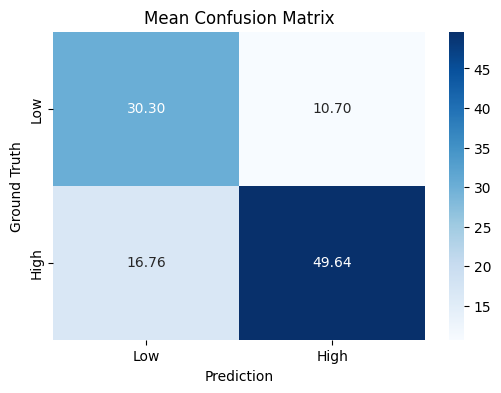

In [66]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__hidden_layer_sizes': [(20), (20, 10)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state))
    ])
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [67]:
outer_results['best_params']

[[{'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.01},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.01},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.01}],
 [{'model__alpha': 0.0001,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.01},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.01},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'm

### 7. Results Table

In [3]:
# Built Table
rq3_data = {
    "Model": ["Support Vector", "Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost", "Multilayer Perceptron"],
    "No-Resampling (Mean)": [.8597, .7572, .8525, .8587, .8044, .8027],
    "No-Resampling (Std)": [  0.00,  1.35,  1.72,  0.32,  0.62,  2.28],
    "Undersampling (Mean)": [.7736, .6371, .7372, .7690, .7875, .7474],
    "Undersampling (Std)": [  0.86,  3.49,  1.65,  1.62,  1.79,  1.73],
    "Oversampling (Mean)":  [.7815, .6885, .8022, .8065, .8126, .7965],
    "Oversampling (Std)":  [  0.89,  3.59,  1.00,  1.90,  1.52,  1.65],
}
df_recall = pd.DataFrame(rq3_data)
df_recall.columns = pd.MultiIndex.from_tuples([
    ('Model', ''),
    ('No-Resampling', 'Avg'),
    ('No-Resampling', 'Std'),
    ('Undersampling', 'Avg'),
    ('Undersampling', 'Std'),
    ('Oversampling', 'Avg'),
    ('Oversampling', 'Std'),
])
df_recall.style.format({
    ('No-Resampling', 'Avg'): lambda x: "{:.2%}".format(x),
    ('No-Resampling', 'Std'): lambda x: "{:.2f}".format(x),
    ('Undersampling', 'Avg'): lambda x: "{:.2%}".format(x),
    ('Undersampling', 'Std'): lambda x: "{:.2f}".format(x),
    ('Oversampling', 'Avg'): lambda x: "{:.2%}".format(x),
    ('Oversampling', 'Std'): lambda x: "{:.2f}".format(x),
}).set_caption("Recall Results for Binary Prediction"
)
